In [1]:
import os, sys, glob
import json, csv, re, datetime
import pickle
import collections

from matplotlib import pyplot as plt
from matplotlib import cm as cm
from tqdm import tqdm
from collections import Counter

from dir_build_dataset_tweets import read_vids

In [2]:
# filter criterion: video must have last-day viewcount of 270+
# vidsfile    = "/home/users/u6314203/pyProject/hip-popularity/data/engage16/filtered/vids_filter_all.csv"
# tweets_dataset_base = "/localdata/u6314203/dataset_tweets"
vidsfile    = "C:/Users/u6314203/pyProjects/hip-popularity/data/engage16/filtered/vids_filter_all.csv"
tweets_dataset_base = "G:/MLCV dataset/engagement'16/tweets_dataset_fixTZ"
engage_dataset_base = "G:/MLCV dataset/engagement'16/tweeted_videos"

categories_eligible = ["autos", "comedy","education","entertainment", \
                       "film","gaming","howto","music",\
                       "news","people","science","sports",\
                       "travel"]

In [3]:
engage_vids = read_vids(vidsfile)
tweets_vids = collections.defaultdict(list)

print("Num. videos in tweets dataset that exist in engage16")
for category in categories_eligible[:]:
    tweetsFile = os.path.join(tweets_dataset_base, "{}.json".format(category))
    with open(tweetsFile, "r") as f:
        tweetsData = json.load(f)
    exists, total  = 0, len(engage_vids[category])
    for vid, _ in tweetsData.items():
        if vid in engage_vids[category]:
            tweets_vids[category].append(vid)
            exists += 1
            
    print("{}: {}/{}".format(category, exists, total))

Num. videos in tweets dataset that exist in engage16
autos: 25597/25712
comedy: 31678/31741
education: 41005/41191
entertainment: 179517/180128
film: 42954/43101
gaming: 221470/222236
howto: 60796/61027
music: 117764/118094
news: 38082/38249
people: 221975/222658
science: 32148/32278
sports: 39537/39649
travel: 13043/13112


#### Profile each category

In [4]:
def engage_days(test_category, eval_days = [90, 135, 180, 225, 270]):
    # read days info in engage16
    with open(os.path.join(engage_dataset_base, test_category+".json"), "r") as f:
        dataset_json = f.readlines()

    # dict-like dataset
    dataset = {}
    # attributes
    vids_set = set()

    for line in tqdm(dataset_json, desc="{} in engage".format(test_category)):
        record = json.loads(line)
        try:        
            day = [int(x) for x in record['insights']['days'].split(",")]
            day_zero = record['insights']['startDate']

            """!!!"""
            if len(day) < eval_days[-1]: continue
        except:
            continue
        dataset[record['id']] = (day_zero, day)

        if record['id'] in vids_set:
            continue
        vids_set.add(record['id'])
        
    return dataset

def tweets_days(test_category):
    with open(os.path.join(tweets_dataset_base, test_category+".json"), "r") as f:
        dataset_json = f.readlines()
        
    dataset = json.loads(dataset_json[0])
    return dataset        

In [5]:
def get_diff_tweets_vs_engage(test_category, engage_dataset, tweets_dataset):    
    diff_tweetsToEngage = {
        "vids": [],
        "day_zero": [],
        "last_day": [],
        "length": []
    }
    
    for vid in tweets_dataset.keys():
        diff_tweetsToEngage["vids"].append(vid)
        record1 = tweets_dataset[vid]['day_zero'], tweets_dataset[vid]['days']
        record2 = engage_dataset[vid]    

        diff_tweetsToEngage["day_zero"].append((datetime.datetime.strptime(record1[0], "%Y-%m-%d") 
                                        - datetime.datetime.strptime(record2[0], "%Y-%m-%d")).days)

        diff_tweetsToEngage["last_day"].append(record1[1][-1] - record2[1][-1])
        diff_tweetsToEngage["length"].append(len(record1[1]) - len(record2[1]))
    return diff_tweetsToEngage

In [6]:
cmap = cm.get_cmap('RdYlBu_r')

def display_diff(test_category, diff_tweetsToEngage):
    Cnt = Counter(diff_tweetsToEngage["day_zero"])
    most_common_diff = [(diff, cnt, "{:.3f}".format(cnt/len(tweets_dataset.keys()))) for diff, cnt in Cnt.most_common(10)]
    print("Top 10 difference of `day_zero`")
    print(test_category, most_common_diff)
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    bin_width = 50
    bins = [x for x in range(min(diff_tweetsToEngage["last_day"])//bin_width*bin_width,
                             max(diff_tweetsToEngage["last_day"])//bin_width*bin_width+bin_width, bin_width)]
    ax.hist(diff_tweetsToEngage["last_day"], rwidth=0.9, bins=bins)
    ax.set_xticks(bins)
    ax.set_title("Histogram of `last_day` difference in {}".format(test_category))
    
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    bin_width = 50
    bins = [x for x in range(min(diff_tweetsToEngage["length"])//bin_width*bin_width,
                             max(diff_tweetsToEngage["length"])//bin_width*bin_width+bin_width, bin_width)]
    ax.hist(diff_tweetsToEngage["length"], rwidth=0.9, bins=bins, log=True)
    ax.set_xticks(bins)
    ax.set_title("Histogram of `length` difference in {} (log)".format(test_category))

#### Problem
1. <s>tweets max 61 days, engage max ~400 days</s>
2. <s>diff_day_zero should not be negative</s> -> user at Youtube can modify publish date
3. <s>In `date`.bz2 file, there can be tweets in both `date`-1 and `date`</s> -> use `created_at` field
4. tweets data are worse missing in last day and length
    - Most videos have 250-300 less records of tweets compared to engage

autos in engage: 100%|█████████████████████████████████████████████████████████| 84796/84796 [00:05<00:00, 15394.71it/s]


autos [(0, 18483, '0.722'), (1, 2621, '0.102'), (2, 705, '0.028'), (3, 449, '0.018'), (4, 279, '0.011'), (5, 216, '0.008'), (6, 211, '0.008'), (7, 167, '0.007'), (8, 144, '0.006'), (10, 134, '0.005')]


comedy in engage: 100%|██████████████████████████████████████████████████████| 138068/138068 [00:07<00:00, 17693.11it/s]


comedy [(0, 24161, '0.763'), (1, 2442, '0.077'), (2, 672, '0.021'), (3, 415, '0.013'), (4, 307, '0.010'), (5, 273, '0.009'), (6, 256, '0.008'), (8, 224, '0.007'), (7, 214, '0.007'), (10, 171, '0.005')]


education in engage: 100%|███████████████████████████████████████████████████| 182849/182849 [00:15<00:00, 11502.68it/s]


education [(0, 29925, '0.730'), (1, 3566, '0.087'), (2, 1073, '0.026'), (3, 617, '0.015'), (4, 530, '0.013'), (5, 450, '0.011'), (6, 386, '0.009'), (7, 315, '0.008'), (8, 250, '0.006'), (9, 213, '0.005')]


entertainment in engage: 100%|███████████████████████████████████████████████| 775941/775941 [00:49<00:00, 15728.25it/s]


entertainment [(0, 135440, '0.754'), (1, 15862, '0.088'), (2, 4290, '0.024'), (3, 2729, '0.015'), (4, 2034, '0.011'), (5, 1616, '0.009'), (6, 1414, '0.008'), (7, 1165, '0.006'), (8, 925, '0.005'), (9, 819, '0.005')]


film in engage: 100%|████████████████████████████████████████████████████████| 194891/194891 [00:11<00:00, 16715.01it/s]


film [(0, 30300, '0.705'), (1, 3892, '0.091'), (2, 1109, '0.026'), (3, 744, '0.017'), (4, 584, '0.014'), (5, 498, '0.012'), (6, 436, '0.010'), (7, 354, '0.008'), (8, 279, '0.006'), (10, 276, '0.006')]


gaming in engage: 100%|████████████████████████████████████████████████████| 1079434/1079434 [01:04<00:00, 16744.93it/s]


gaming [(0, 189105, '0.854'), (1, 11933, '0.054'), (2, 2753, '0.012'), (3, 1799, '0.008'), (4, 1322, '0.006'), (5, 1152, '0.005'), (-1, 1004, '0.005'), (6, 991, '0.004'), (7, 788, '0.004'), (8, 689, '0.003')]


howto in engage: 100%|███████████████████████████████████████████████████████| 192931/192931 [00:13<00:00, 14051.42it/s]


howto [(0, 47203, '0.776'), (1, 5017, '0.083'), (2, 1295, '0.021'), (3, 805, '0.013'), (4, 595, '0.010'), (5, 448, '0.007'), (6, 408, '0.007'), (7, 383, '0.006'), (9, 290, '0.005'), (8, 279, '0.005')]


music in engage: 100%|███████████████████████████████████████████████████████| 449314/449314 [00:27<00:00, 16179.57it/s]


music [(0, 81663, '0.693'), (1, 11875, '0.101'), (2, 3432, '0.029'), (3, 2143, '0.018'), (4, 1664, '0.014'), (5, 1359, '0.012'), (6, 1128, '0.010'), (7, 989, '0.008'), (8, 876, '0.007'), (9, 737, '0.006')]


news in engage: 100%|████████████████████████████████████████████████████████| 459728/459728 [00:21<00:00, 21172.77it/s]


news [(0, 28207, '0.741'), (1, 4208, '0.110'), (2, 1007, '0.026'), (3, 573, '0.015'), (4, 463, '0.012'), (5, 351, '0.009'), (6, 292, '0.008'), (7, 228, '0.006'), (8, 206, '0.005'), (9, 166, '0.004')]


people in engage: 100%|████████████████████████████████████████████████████| 1265805/1265805 [01:09<00:00, 18169.82it/s]


people [(0, 143750, '0.648'), (1, 22020, '0.099'), (2, 6720, '0.030'), (3, 4253, '0.019'), (4, 3405, '0.015'), (5, 2886, '0.013'), (6, 2614, '0.012'), (7, 2264, '0.010'), (8, 1912, '0.009'), (9, 1804, '0.008')]


science in engage: 100%|█████████████████████████████████████████████████████| 110635/110635 [00:07<00:00, 15106.87it/s]


science [(0, 24764, '0.770'), (1, 2530, '0.079'), (2, 674, '0.021'), (3, 475, '0.015'), (4, 327, '0.010'), (5, 266, '0.008'), (6, 238, '0.007'), (7, 193, '0.006'), (8, 171, '0.005'), (9, 150, '0.005')]


C:\Users\u6314203\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Users\u6314203\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
sports in engage: 100%|██████████████████████████████████████████████████████| 243650/243650 [00:12<00:00, 18747.64it/s]


sports [(0, 29553, '0.747'), (1, 4161, '0.105'), (2, 975, '0.025'), (3, 635, '0.016'), (4, 432, '0.011'), (5, 342, '0.009'), (6, 276, '0.007'), (7, 242, '0.006'), (9, 187, '0.005'), (8, 179, '0.005')]


travel in engage: 100%|████████████████████████████████████████████████████████| 65155/65155 [00:03<00:00, 16775.53it/s]


travel [(0, 9309, '0.714'), (1, 1283, '0.098'), (2, 370, '0.028'), (3, 236, '0.018'), (4, 179, '0.014'), (5, 140, '0.011'), (7, 111, '0.009'), (6, 101, '0.008'), (8, 89, '0.007'), (11, 84, '0.006')]


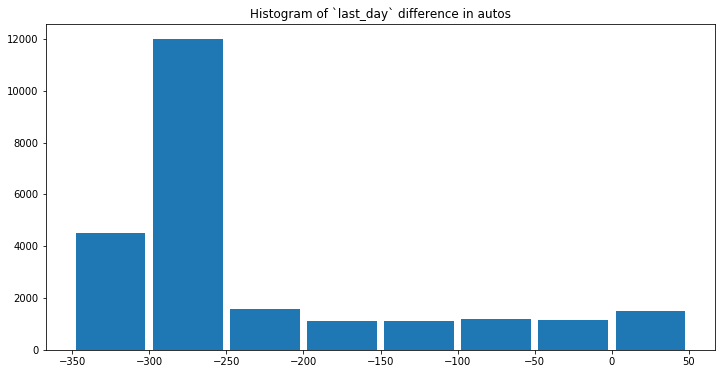

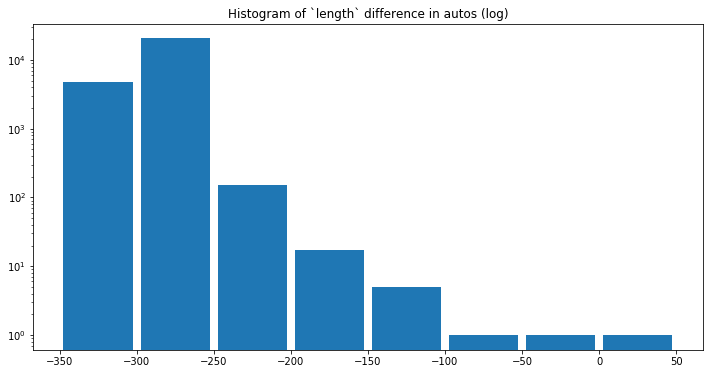

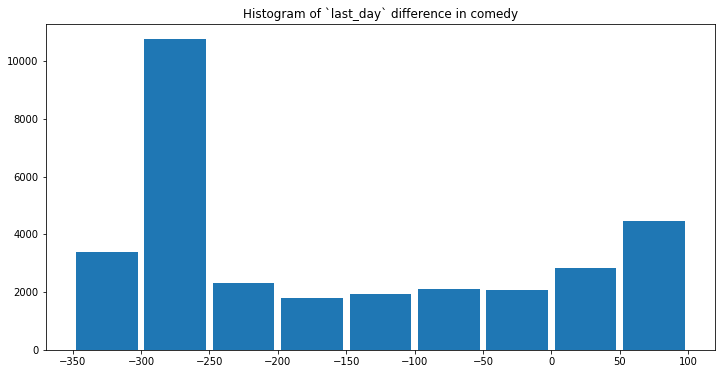

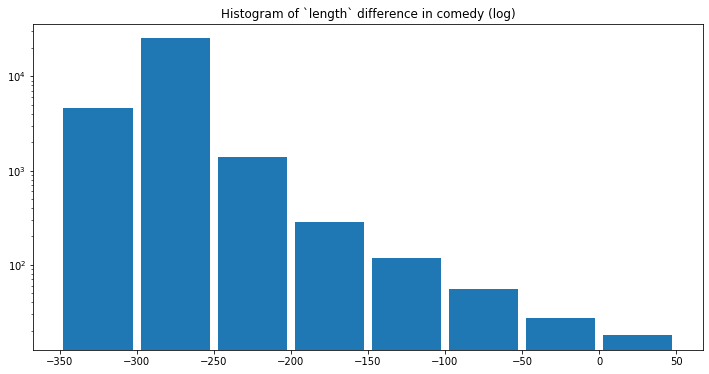

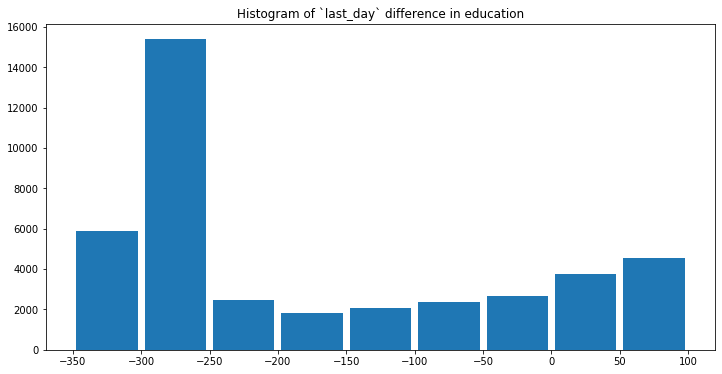

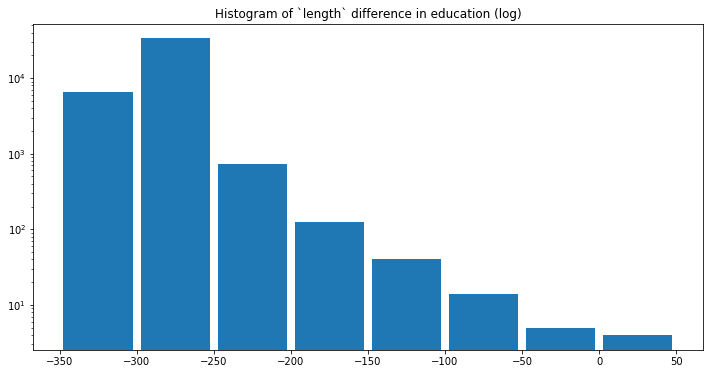

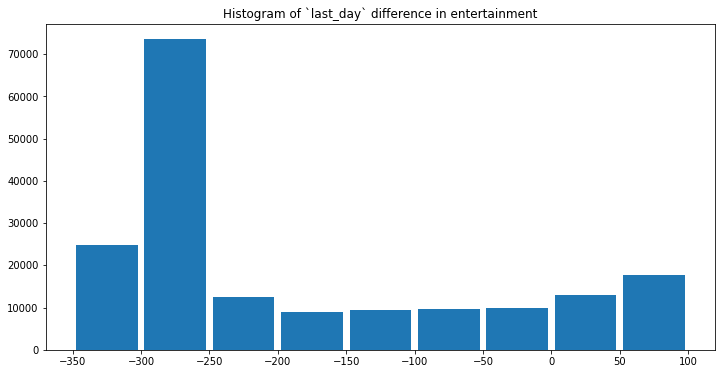

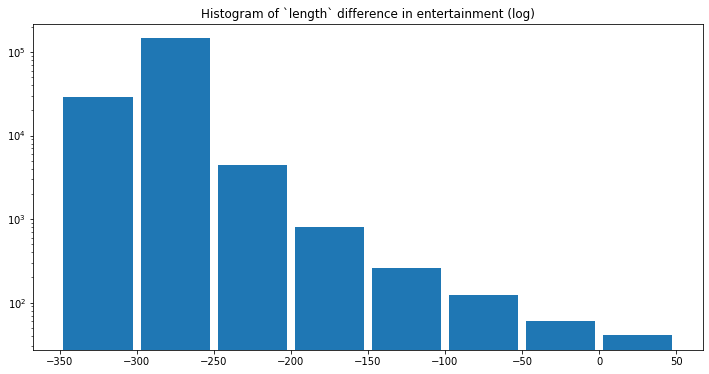

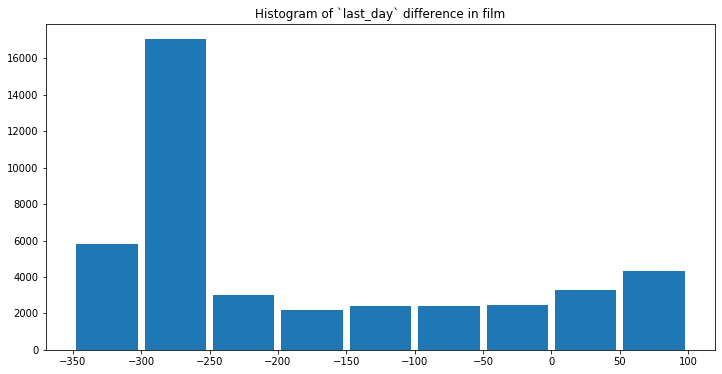

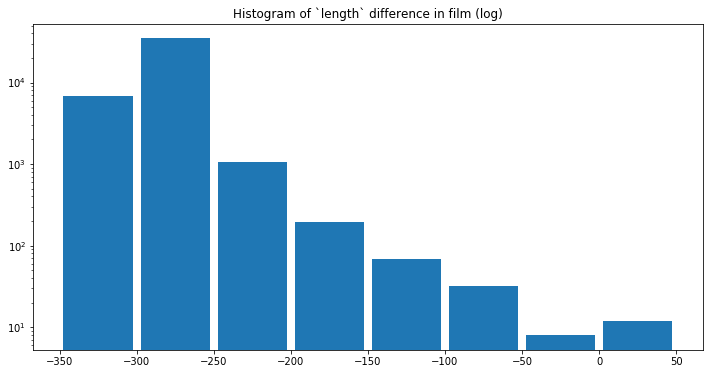

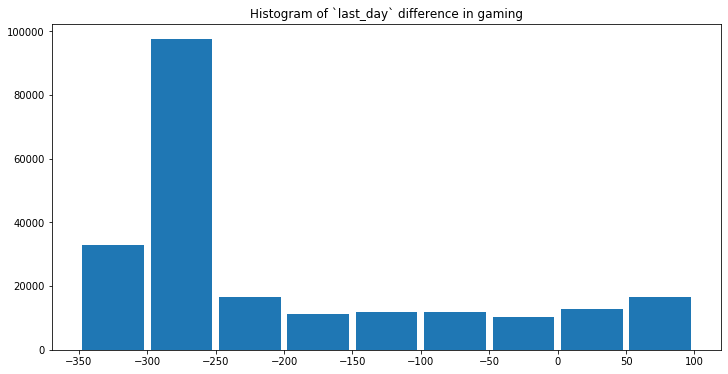

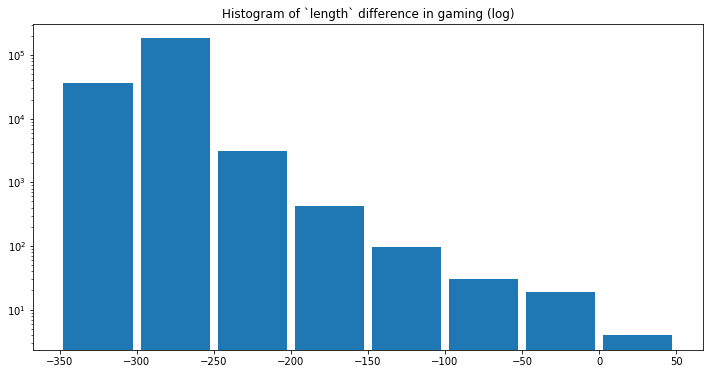

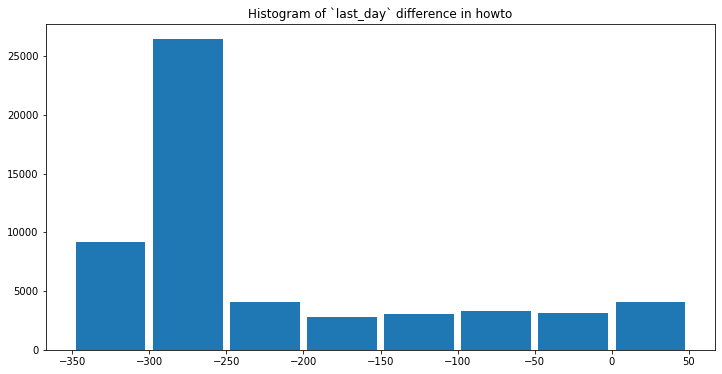

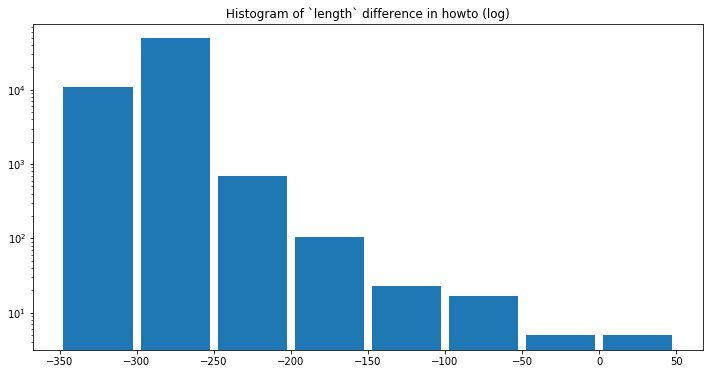

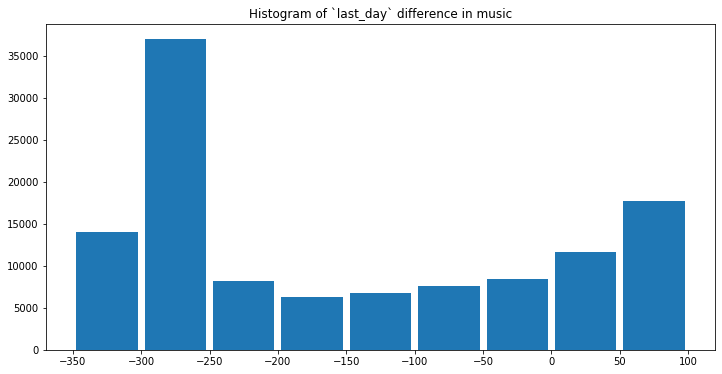

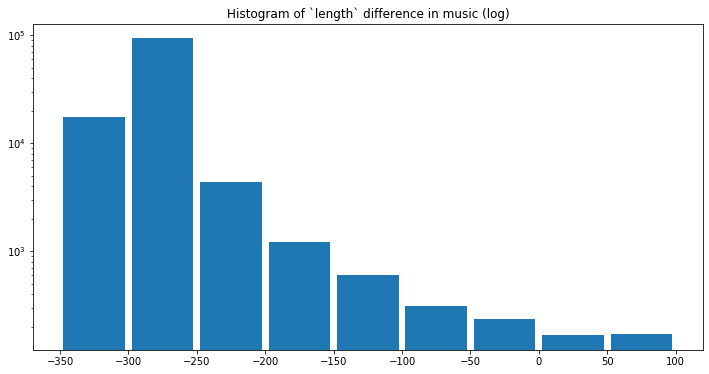

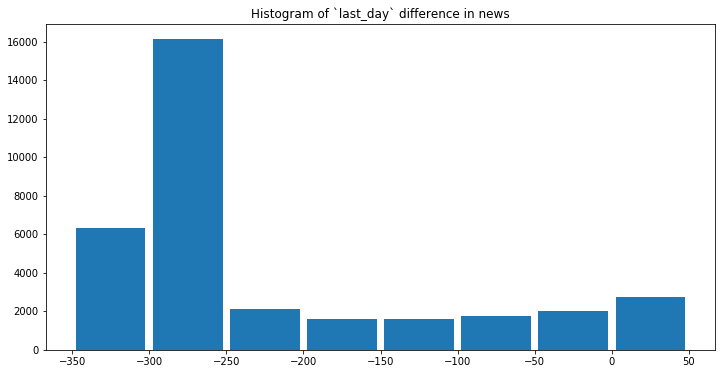

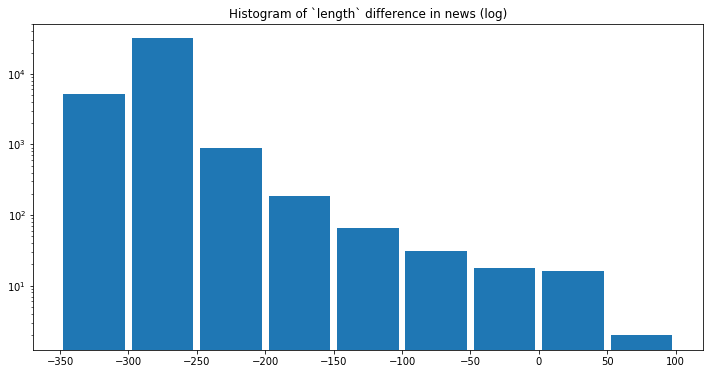

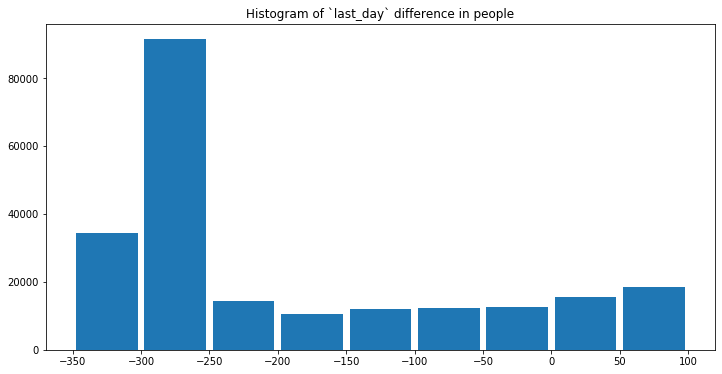

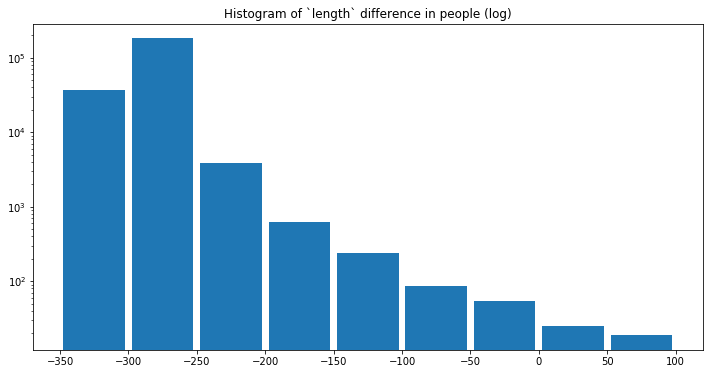

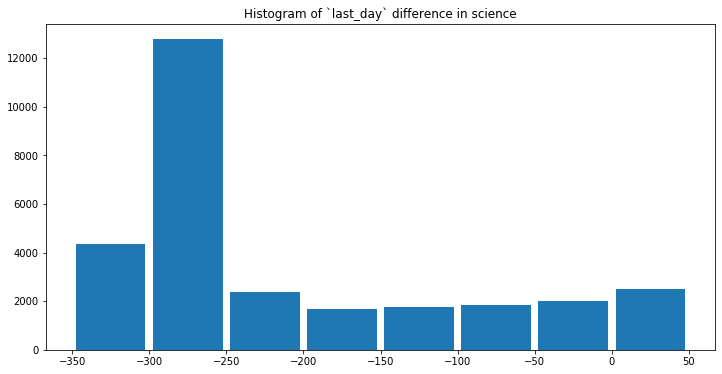

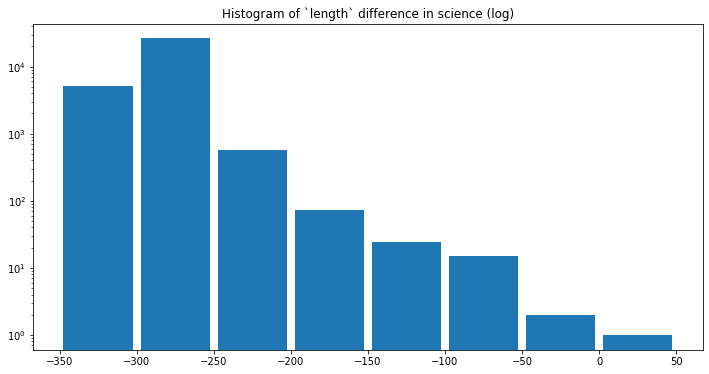

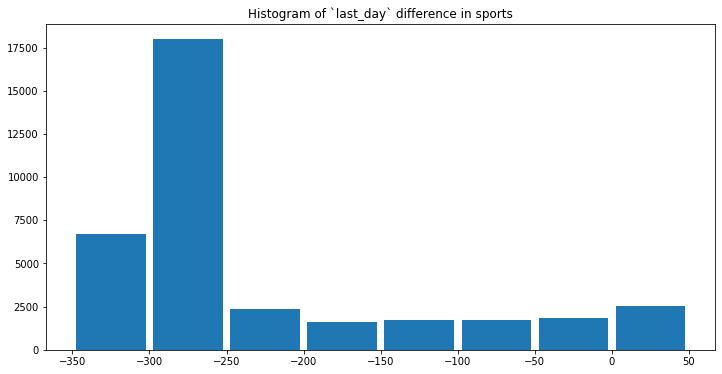

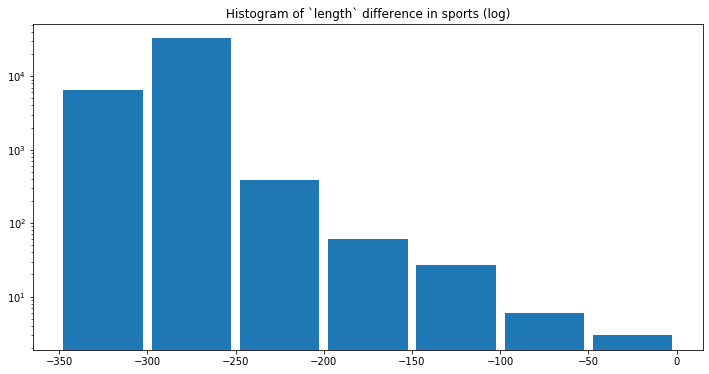

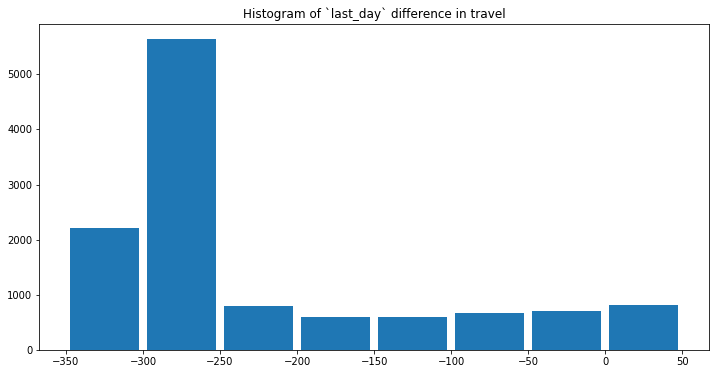

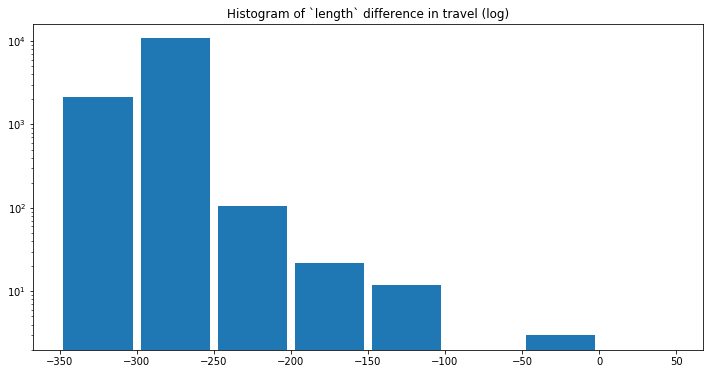

In [7]:
for test_category in categories_eligible[:]:
    engage_dataset = engage_days(test_category)
    tweets_dataset = tweets_days(test_category)
    diff_tweetsToEngage = get_diff_tweets_vs_engage(test_category, engage_dataset, tweets_dataset)
    display_diff(test_category, diff_tweetsToEngage)